In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score

Epoch 1/1000
 1/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - MAPE: 347.6599 - loss: 1.4327

2025-03-21 11:32:52.483683: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 11:32:52.484131: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAPE: 224.0832 - loss: 1.0429 - val_MAPE: 299.7670 - val_loss: 0.3246
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAPE: 162.9721 - loss: 0.2691 - val_MAPE: 251.0229 - val_loss: 0.1824
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAPE: 113.4399 - loss: 0.1662 - val_MAPE: 166.1122 - val_loss: 0.1276
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAPE: 98.5611 - loss: 0.1255 - val_MAPE: 125.8688 - val_loss: 0.1019
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAPE: 91.1593 - loss: 0.1082 - val_MAPE: 105.9182 - val_loss: 0.0896
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAPE: 78.8032 - loss: 0.0989 - val_MAPE: 94.7348 - val_loss: 0.0808
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAPE: 69.9671 - loss: 0.0912 - val_MAPE: 85.6530 - val_loss: 0.0743
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MAPE: 65.7978 - loss: 0.0853 - val_MAPE: 74.0337 - val_loss: 0.0686
Epoch 9/1000
22/22 ━━━━━━━━━━

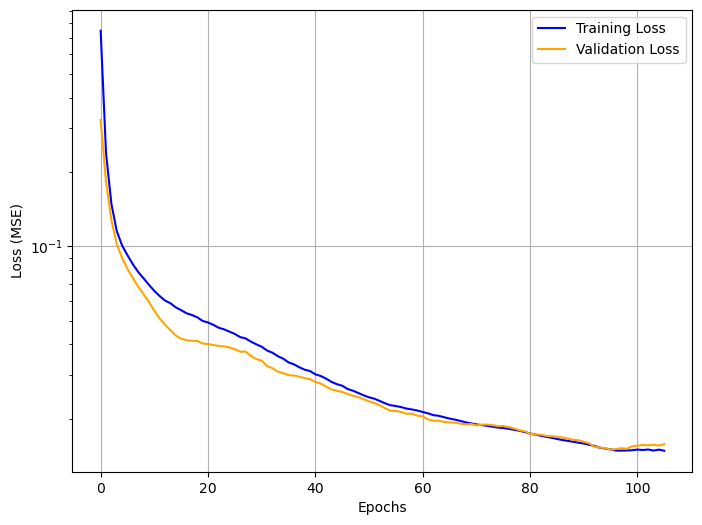

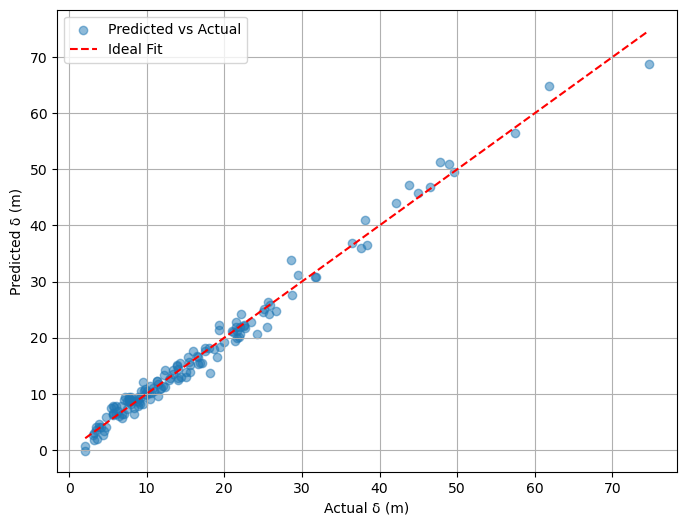

In [4]:
# ======= Uncomment for Full Reproducibility (good for debugging or model comparisons) =======
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()  # Enable deterministic operations in TensorFlow
tf.keras.backend.clear_session()  # Set TensorFlow backend to deterministic mode

# ======= Load Dataset =======
filename = "Dataset_BeamNaturalFrequency.txt"
df = pd.read_csv(filename, sep='\t')
X = df[['E (Pa)', 'I (m^4)', 'ρ (kg/m^3)', 'A (m^2)', 'L (m)']].values  # Inputs
Y = df[['f (Hz)']].values  # Output

# ======= Data Preprocessing =======
# Split into training, validation, and test sets (70% train, 15% val, 15% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Standardize inputs and outputs
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

Y_train = scaler_Y.fit_transform(Y_train)
Y_val = scaler_Y.transform(Y_val)
Y_test = scaler_Y.transform(Y_test)

# ======= Build Neural Network =======
model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input Layer
    layers.Dense(10, activation='relu'),  # Hidden Layer - try 'sigmoid', 'tanh', 'relu', or 'leaky_relu'
    layers.Dense(1)  # Output Layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='MSE', metrics=['MAPE'])  # Try different optimisers (SGD, Adam etc.)

# ======= Train Model with Early Stopping =======
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop after 10 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1000,
    batch_size=32,  # Try different batch sizes (16, 32, 64, 128, etc.)
    verbose=1,
    callbacks=[early_stopping]
)

# ======= Model Evaluation =======
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Convert predictions back to original scale
def inverse_transform_and_evaluate(X, Y, scaler_Y, dataset_name):
    Y_pred = model.predict(X)
    Y_pred_original = scaler_Y.inverse_transform(Y_pred)
    Y_original = scaler_Y.inverse_transform(Y)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean(np.abs((Y_original - Y_pred_original) / Y_original)) * 100
    print(f'\n MAPE_{dataset_name} (%)', MAPE)

    return Y_original, Y_pred_original, MAPE

# Evaluate on training, validation, and test sets
Y_train_original, Y_train_pred_original, MAPE_train = inverse_transform_and_evaluate(X_train, Y_train, scaler_Y, "train")
Y_val_original, Y_val_pred_original, MAPE_val = inverse_transform_and_evaluate(X_val, Y_val, scaler_Y, "val")
Y_test_original, Y_test_pred_original, MAPE_test = inverse_transform_and_evaluate(X_test, Y_test, scaler_Y, "test")


# ======= Visualization =======
# Loss vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.yscale('log')  # Log scale for better visualization
plt.show()

# Scatter plot of Actual vs. Predicted for Validation Set
plt.figure(figsize=(8, 6))
plt.scatter(Y_val_original, Y_val_pred_original, alpha=0.5, label='Predicted vs Actual')
plt.plot([Y_val_original.min(), Y_val_original.max()],
         [Y_val_original.min(), Y_val_original.max()],
         color='red', linestyle='--', label='Ideal Fit')  # Line of perfect predictions
plt.xlabel('Actual δ (m)')
plt.ylabel('Predicted δ (m)')
plt.legend()
plt.grid()
plt.show()


In [6]:
def train_beam_frequency_model(activation='relu', optimizer_name='adam',
                               num_layers=1, neurons_per_layer=10,
                               learning_rate=0.01, batch_size=32, max_epochs=1000,
                               deterministic=True):
    # Optional deterministic setup
    if deterministic:
        seed = 42
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        tf.config.experimental.enable_op_determinism()
        tf.keras.backend.clear_session()

    # Load Dataset
    df = pd.read_csv("Dataset_BeamNaturalFrequency.txt", sep='\t')
    X = df[['E (Pa)', 'I (m^4)', 'ρ (kg/m^3)', 'A (m^2)', 'L (m)']].values
    Y = df[['f (Hz)']].values

    # Preprocessing
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)
    Y_train = scaler_Y.fit_transform(Y_train)
    Y_val = scaler_Y.transform(Y_val)
    Y_test = scaler_Y.transform(Y_test)

    # Build Model
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(layers.Dense(neurons_per_layer, activation=activation))
    model.add(layers.Dense(1))  # Output layer

    # Choose optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose 'adam' or 'sgd'.")

    # Compile
    model.compile(optimizer=optimizer, loss='mse', metrics=['mape'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=max_epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[early_stopping])

    # Final evaluation on test set
    Y_test_pred = model.predict(X_test)
    Y_test_pred_orig = scaler_Y.inverse_transform(Y_test_pred)
    Y_test_orig = scaler_Y.inverse_transform(Y_test)

    mape = np.mean(np.abs((Y_test_orig - Y_test_pred_orig) / Y_test_orig)) * 100
    mae = mean_absolute_error(Y_test_orig, Y_test_pred_orig)
    r2 = r2_score(Y_test_orig, Y_test_pred_orig)

    print(f"\n=== FINAL TEST METRICS ===")
    print(f"MAPE: {mape:.2f}%")
    print(f"MAE:  {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Combined Plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1 - Loss curve
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss (MSE)')
    axs[0].set_yscale('log')
    axs[0].set_title('Loss Curve')
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2 - Predicted vs Actual
    axs[1].scatter(Y_test_orig, Y_test_pred_orig, alpha=0.6, label='Predicted vs Actual')
    min_val = min(Y_test_orig.min(), Y_test_pred_orig.min())
    max_val = max(Y_test_orig.max(), Y_test_pred_orig.max())
    axs[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
    axs[1].set_xlabel('Actual f (Hz)')
    axs[1].set_ylabel('Predicted f (Hz)')
    axs[1].set_title('Test Set Predictions')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model


2025-03-21 11:41:58.971958: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 11:41:58.972223: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


2025-03-21 11:42:07.009434: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 11:42:07.009712: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 6.63%
MAE:  0.7568
R² Score: 0.9875


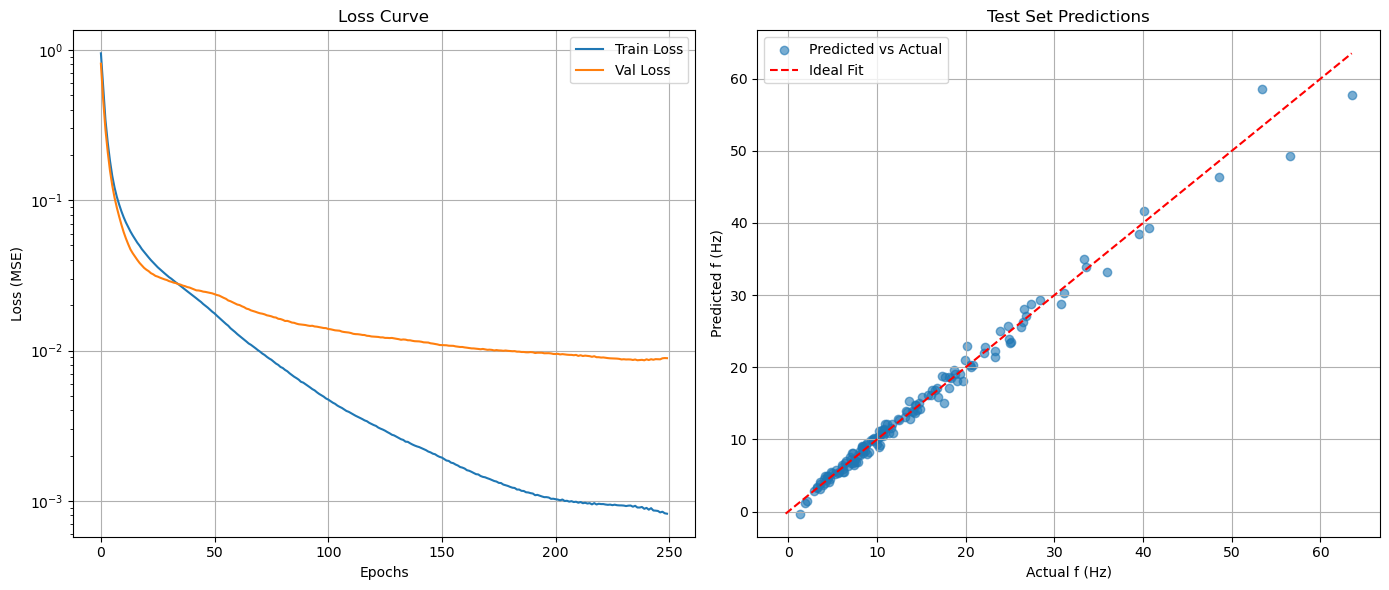

In [12]:
model = train_beam_frequency_model(
    activation='relu',
    optimizer_name='adam',
    num_layers=2,
    neurons_per_layer=32,
    learning_rate=0.001,
    deterministic=True  # Full reproducibility
)

2025-03-21 11:50:32.421238: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 11:50:32.421484: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


2025-03-21 11:50:38.509139: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 11:50:38.509396: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 5.80%
MAE:  0.6985
R² Score: 0.9891


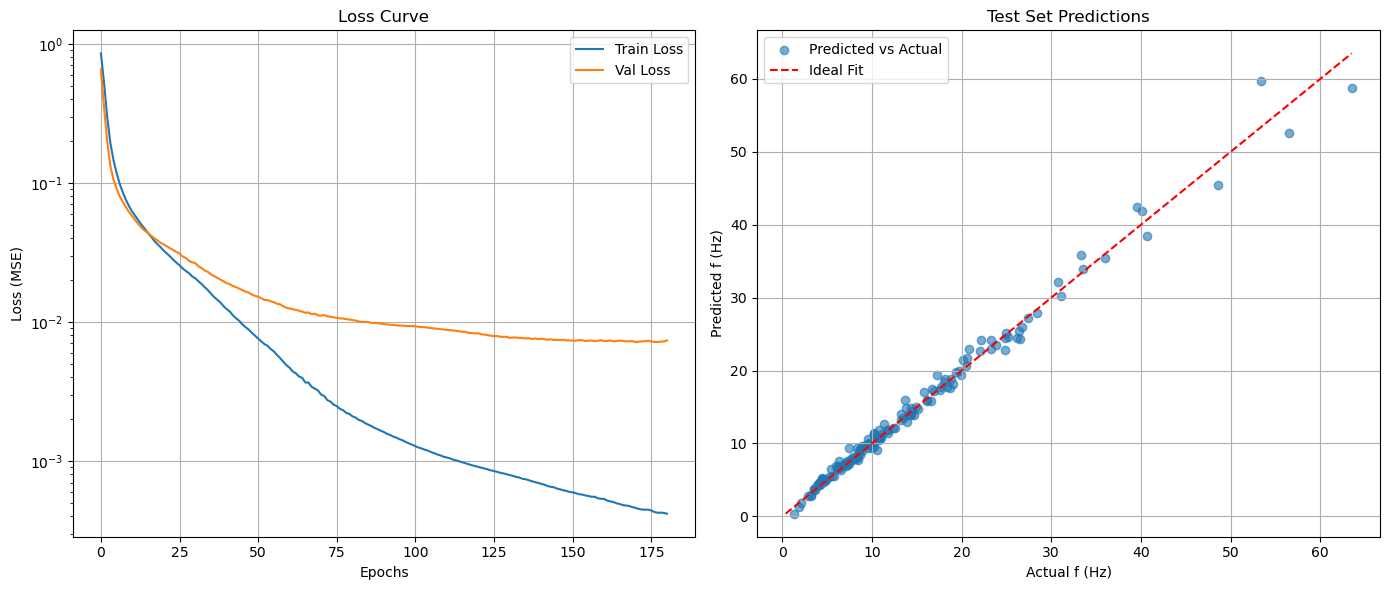

In [14]:
model = train_beam_frequency_model(
    activation='relu',
    optimizer_name='adam',
    num_layers=3,
    neurons_per_layer=32,
    learning_rate=0.001,
    deterministic=True  # Full reproducibility
)

2025-03-21 11:54:29.865645: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 11:54:29.865915: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-03-21 11:54:38.369940: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 11:54:38.370202: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 5.29%
MAE:  0.7056
R² Score: 0.9864


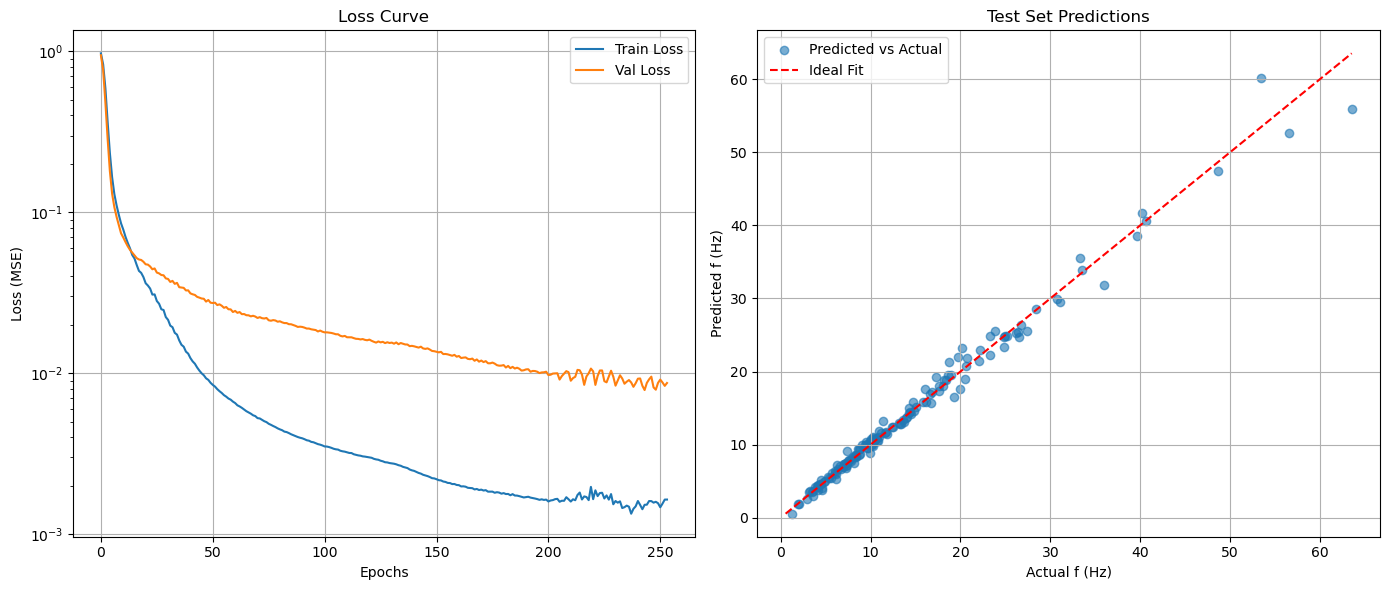

In [18]:
model = train_beam_frequency_model(
    activation='relu',
    optimizer_name='adam',
    num_layers=5,
    neurons_per_layer=16,
    learning_rate=0.001,
    deterministic=True  # Full reproducibility
)

5 Layers, 16 Neurons, activation = sigmoid

2025-03-21 11:57:27.359585: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 11:57:27.359858: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-03-21 11:58:00.050165: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 11:58:00.050435: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 3.70%
MAE:  0.4358
R² Score: 0.9967


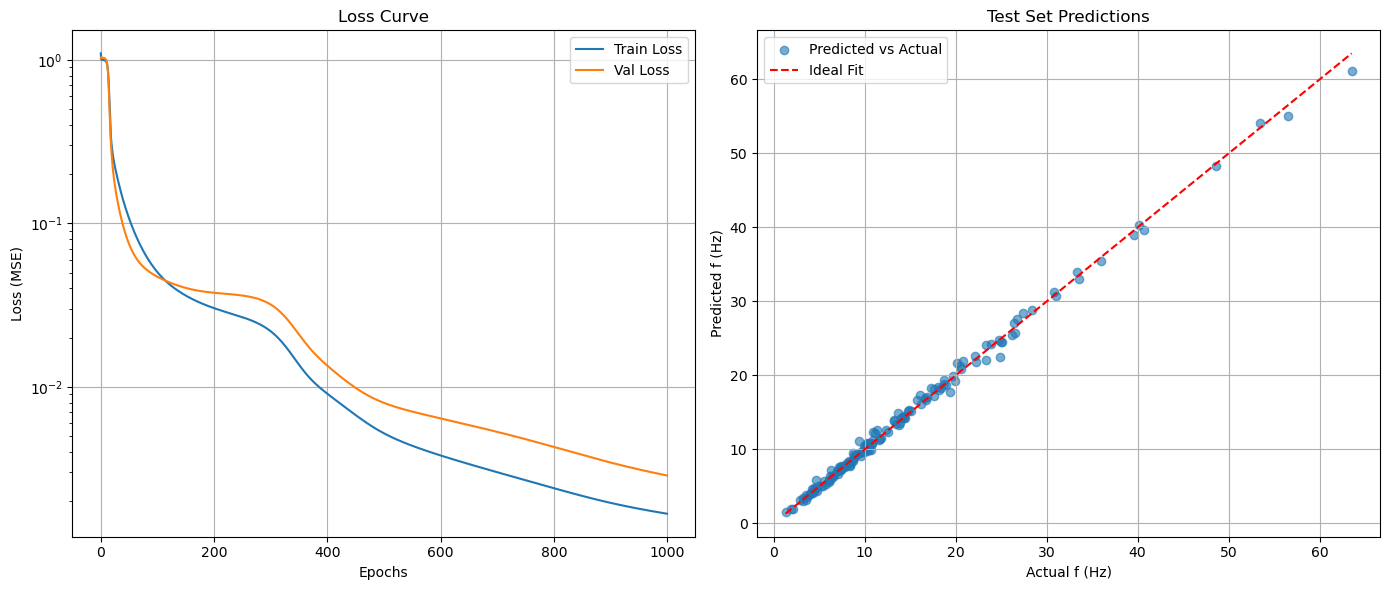

In [20]:
model = train_beam_frequency_model(
    activation='sigmoid',
    optimizer_name='adam',
    num_layers=5,
    neurons_per_layer=16,
    learning_rate=0.001,
    deterministic=True  # Full reproducibility
)

5 Layers, 16 Neurons, activation = tanh

2025-03-21 11:58:24.196806: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 11:58:24.197074: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-03-21 11:58:31.685591: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 11:58:31.685826: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 3.86%
MAE:  0.4804
R² Score: 0.9914


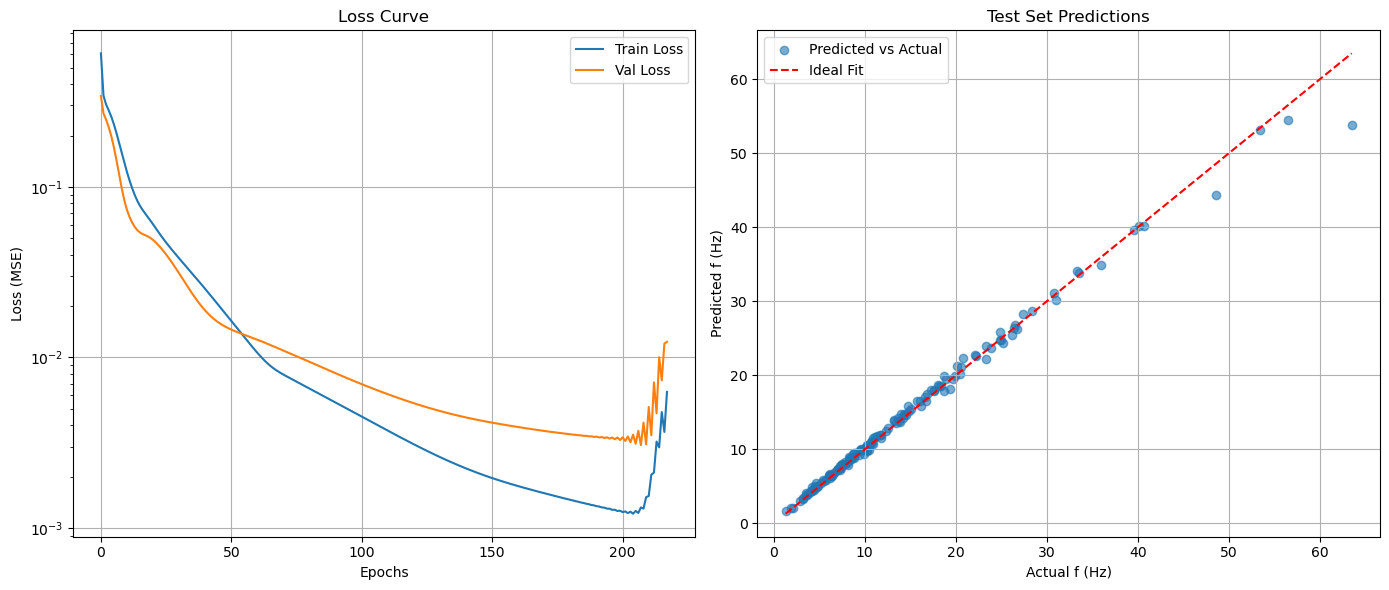

In [21]:
model = train_beam_frequency_model(
    activation='tanh',
    optimizer_name='adam',
    num_layers=5,
    neurons_per_layer=16,
    learning_rate=0.001,
    deterministic=True  # Full reproducibility
)

5 Layers, 16 Neurons, activation = relu

2025-03-21 11:59:54.664174: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 11:59:54.664423: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-03-21 12:00:03.377023: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 12:00:03.377301: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 5.29%
MAE:  0.7056
R² Score: 0.9864


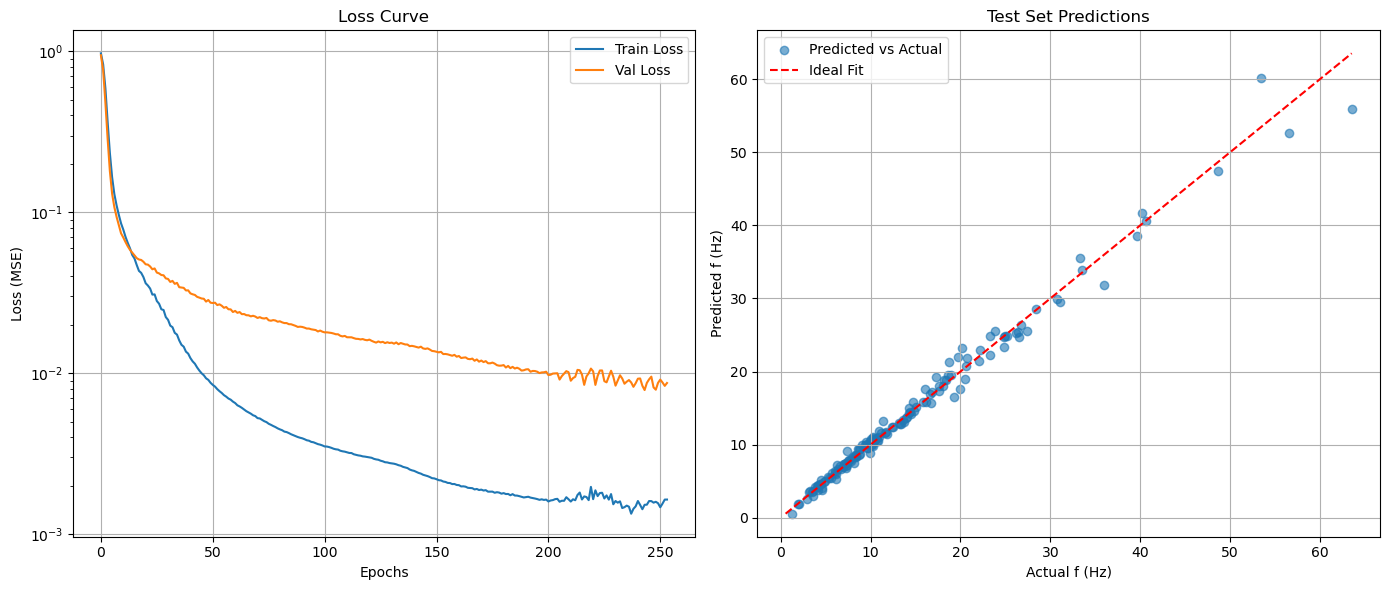

In [23]:
model = train_beam_frequency_model(
    activation='relu',
    optimizer_name='adam',
    num_layers=5,
    neurons_per_layer=16,
    learning_rate=0.001,
    deterministic=True  # Full reproducibility
)

5 Layers, 16 Neurons, activation = leaky relu

2025-03-21 12:01:14.662036: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 12:01:14.662289: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-03-21 12:01:22.558934: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 12:01:22.559173: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 5.17%
MAE:  0.5894
R² Score: 0.9932


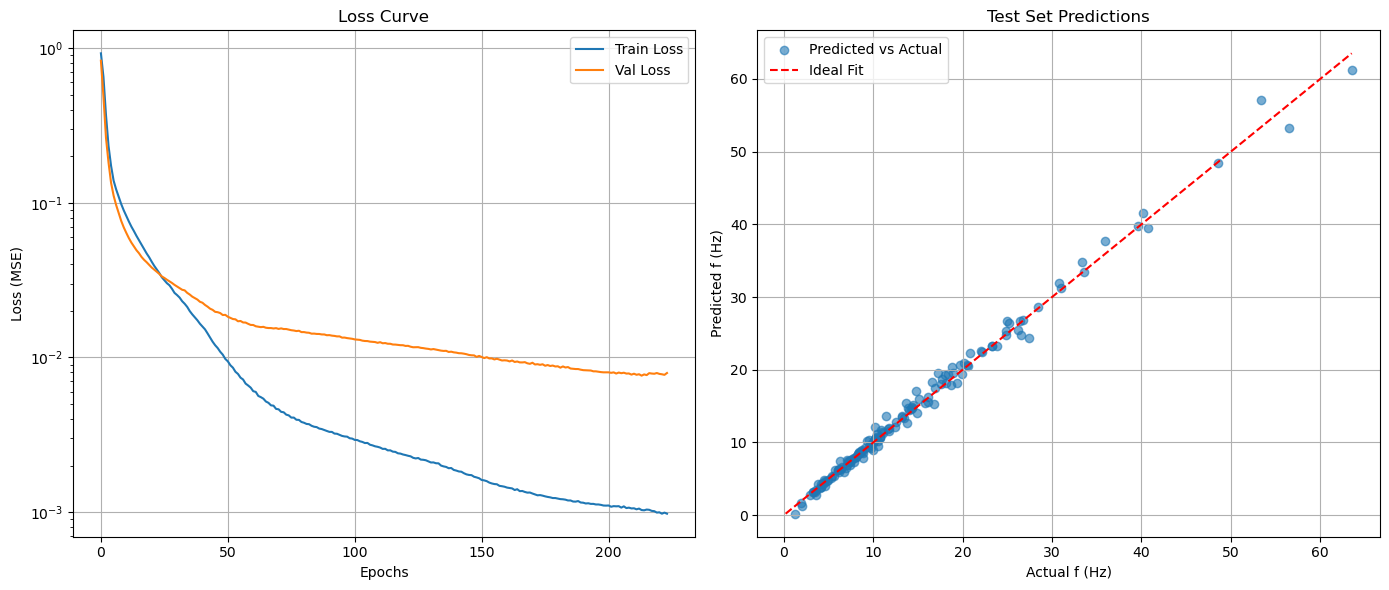

In [25]:
model = train_beam_frequency_model(
    activation='leaky_relu',
    optimizer_name='adam',
    num_layers=5,
    neurons_per_layer=16,
    learning_rate=0.001,
    deterministic=True  # Full reproducibility
)

5 Layers, 16 Neurons, activation = relu, optimiser: SGD, learning rate = 0.01

2025-03-21 12:05:25.192856: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 12:05:25.193128: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

=== FINAL TEST METRICS ===
MAPE: 6.05%
MAE:  0.6948
R² Score: 0.9913


2025-03-21 12:05:40.324772: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 12:05:40.324997: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

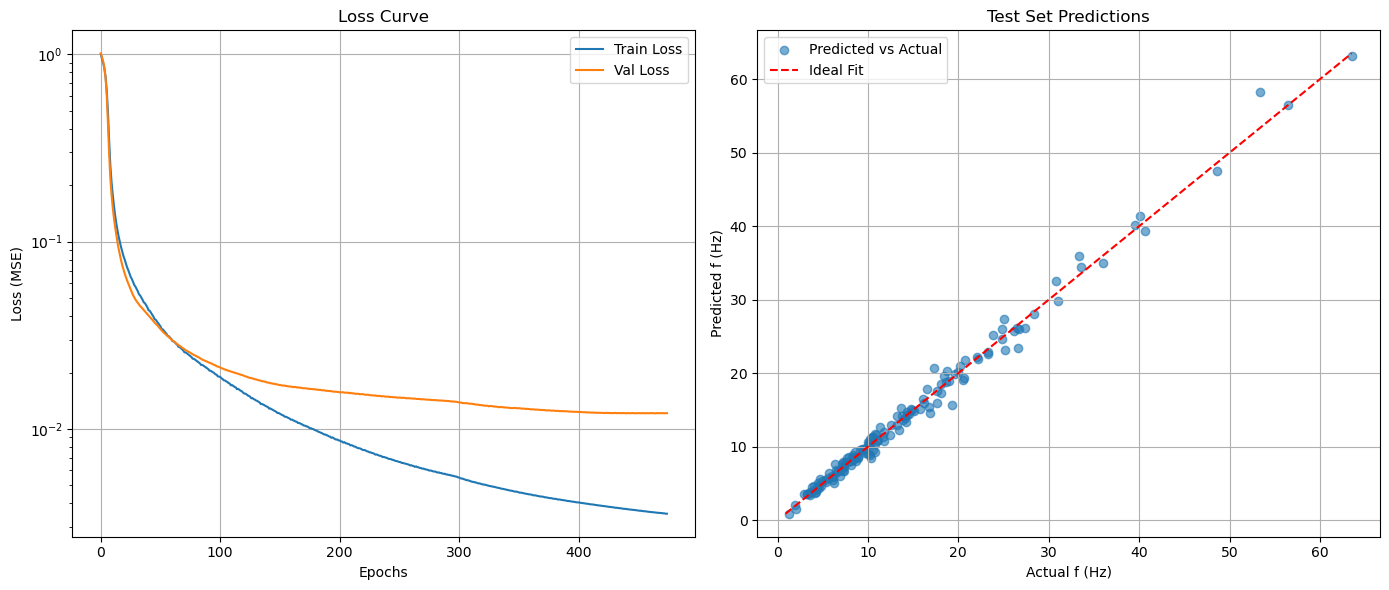

In [30]:
model = train_beam_frequency_model(
    activation='relu',
    optimizer_name='SGD',
    num_layers=5,
    neurons_per_layer=16,
    learning_rate=0.01,
    deterministic=True  # Full reproducibility
)

2025-03-21 12:10:56.061237: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 12:10:56.061619: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-03-21 12:11:27.074204: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-21 12:11:27.074443: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== FINAL TEST METRICS ===
MAPE: 3.25%
MAE:  0.3786
R² Score: 0.9974


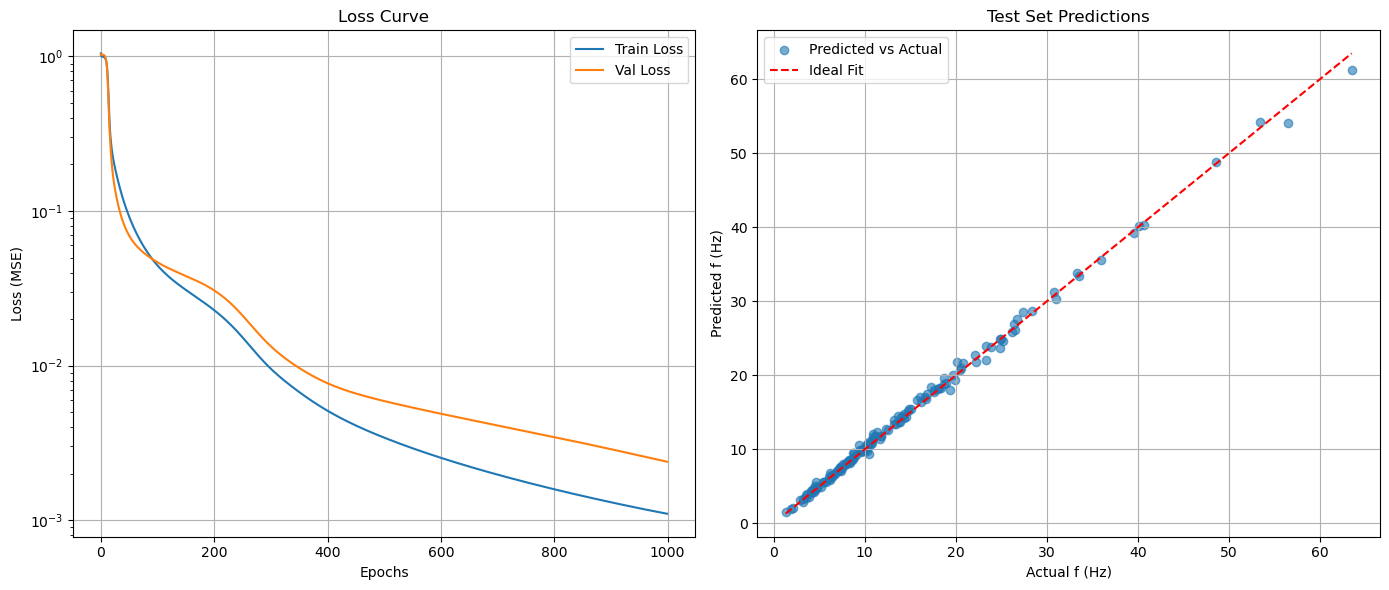

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted natural frequency (Hz): 22.9041


In [33]:
model = train_beam_frequency_model(
    activation='sigmoid',
    optimizer_name='adam',
    num_layers=5,
    neurons_per_layer=16,
    learning_rate=0.001,
    deterministic=False
)


# Beam input
new_beam = np.array([[50e9, 2e-5, 7800, 5e-3, 2.0]])

# Standardize
new_beam_scaled = scaler_X.transform(new_beam)

# Predict
predicted_scaled = model.predict(new_beam_scaled)

# Inverse transform to original scale
predicted_freq = scaler_Y.inverse_transform(predicted_scaled)
print(f"Predicted natural frequency (Hz): {predicted_freq[0][0]:.4f}")


# Fuselage Stiffness Study

In [2]:
def train_buckling_model(activation='relu', optimizer_name='adam',
                          num_layers=1, neurons_per_layer=10,
                          learning_rate=0.01, batch_size=32, max_epochs=1000,
                          deterministic=True, filename="Dataset_FuselagePanel.txt"):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import random
    import tensorflow as tf
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import layers
    from tensorflow.keras.optimizers import Adam, SGD
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_absolute_error, r2_score

    if deterministic:
        seed = 42
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        tf.config.experimental.enable_op_determinism()
        tf.keras.backend.clear_session()

    # Load dataset
    df = pd.read_csv(filename, sep='\t')  # Update separator if needed
    X = df.iloc[:, 0:18].values  # First 18 columns = input features
    Y = df.iloc[:, 18].values.reshape(-1, 1)  # Last column = Bmin target

    # Split sets
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    # Standardize
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)
    Y_train = scaler_Y.fit_transform(Y_train)
    Y_val = scaler_Y.transform(Y_val)
    Y_test = scaler_Y.transform(Y_test)

    # Build model
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(layers.Dense(neurons_per_layer, activation=activation))
    model.add(layers.Dense(1))

    # Optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose 'adam' or 'sgd'.")

    model.compile(optimizer=optimizer, loss='mse', metrics=['mape'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=max_epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[early_stopping])

    # Evaluate on test set
    Y_test_pred = model.predict(X_test)
    Y_test_pred_orig = scaler_Y.inverse_transform(Y_test_pred)
    Y_test_orig = scaler_Y.inverse_transform(Y_test)

    mape = np.mean(np.abs((Y_test_orig - Y_test_pred_orig) / Y_test_orig)) * 100
    mae = mean_absolute_error(Y_test_orig, Y_test_pred_orig)
    r2 = r2_score(Y_test_orig, Y_test_pred_orig)

    print(f"\n=== FINAL TEST METRICS ===")
    print(f"MAPE: {mape:.2f}%")
    print(f"MAE:  {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss (MSE)')
    axs[0].set_yscale('log')
    axs[0].set_title('Loss Curve')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].scatter(Y_test_orig, Y_test_pred_orig, alpha=0.6, label='Predicted vs Actual')
    min_val = min(Y_test_orig.min(), Y_test_pred_orig.min())
    max_val = max(Y_test_orig.max(), Y_test_pred_orig.max())
    axs[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
    axs[1].set_xlabel('Actual Bmin')
    axs[1].set_ylabel('Predicted Bmin')
    axs[1].set_title('Test Set Predictions')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, scaler_X, scaler_Y


In [ ]:
model, scaler_X, scaler_Y = train_buckling_model(
    activation='tanh',
    optimizer_name='adam',
    num_layers=1,
    neurons_per_layer=32,
    learning_rate=0.001,
    deterministic=True
)


2025-03-21 12:27:33.039688: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-21 12:27:33.039948: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),